# Case Study 4: Computational Methods in Finance

# Charles Laferte - cl4249

In [5]:
import modulesForCalibration as mfc

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

from scipy.optimize import fmin, fmin_bfgs, minimize
from scipy.stats import norm

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm

## Simulate the market data with Heston Stochastic Volatility Model

Let's set the parameters we will consider for the Heston model:

In [228]:
'''
kappa  = params[0];
theta  = params[1];
sigma  = params[2];
rho    = params[3];
v0     = params[4];
'''
S0 = 4100
r = 0.0485
mu = r
params = [0.02, 1.5, 0.05, 0.18, 0.5, 0.04]


In [88]:
N = 10*252 # 10 years * 252 trading day per year
T = 10
dt = T/N

In [97]:
def heston_simulated_prices(params, N, T, S0, r, mu, plot = False):
    kappa  = params[0]
    theta  = params[1]
    sigma  = params[2]
    rho    = params[3]
    v0     = params[4]
    
    # Define discretization parameters
    dt = T/N        # time increment
    M = 1           # number of simulations
    print('T:',T,'  N:', N, '  dt:', dt)
    print(v0)

    # Generate random numbers
    Z1 = norm.rvs(size=(N, M))
    Z2 = rho*Z1 + np.sqrt(1-rho**2)*norm.rvs(size=(N, M))

    # Define arrays to store stock price and volatility paths
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))

    # Set initial values
    S[0,:] = S0
    v[0,:] = v0 #theta
    print(v0)
    
    # Calculate paths
    for i in range(N):
        v[i+1,:] = np.maximum(0, v[i,:] + kappa*(theta-v[i,:])*dt + sigma*np.sqrt(v[i,:])*np.sqrt(dt)*Z1[i,:])
        #print(v[i+1,:])
        S[i+1,:] = S[i,:] * np.exp((mu - 0.5*v[i,:])*dt + np.sqrt(v[i,:])*np.sqrt(dt)*Z2[i,:])
        #print(S[i+1,:])
    
    # Plot results
    if plot == True:
        plt.plot(S)
        plt.title('Simulated Heston Model Stock Price Path')
        plt.xlabel('Time Steps')
        plt.ylabel('Stock Price')
        plt.show()
    
        plt.plot(v)
        plt.title('Simulated Heston Model volatility Path')
        plt.xlabel('Time Steps')
        plt.ylabel('Volatility')
        plt.show()
        
    # Reshaping the outputs
    y = np.log(S)
    S = S.T
    S = S[0]
    v = v.T
    v = v[0]
    y = y.T
    y = y[0]
    
    return S, v, y
    

[1.5  0.05 0.18 0.5  0.04]
T: 10   N: 500   dt: 0.02
0.04
0.04


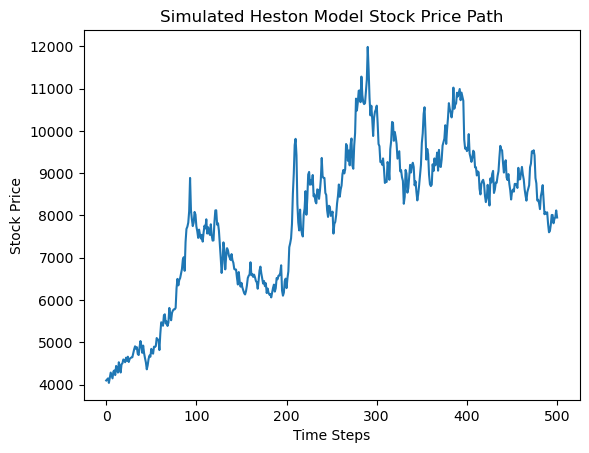

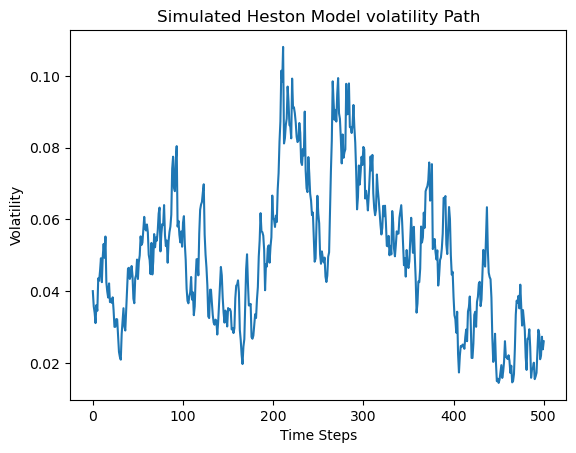

In [229]:
#prices, v_, y = heston_simulated_prices(params, N, T, S0, r, mu, plot = True)
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lambda_, rho , v0
N = 500
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

## 1. Extended Kalman Filter

In [99]:
def ext_Kalman_filter(params):
    
    global y_KF, v_KF
    
    mu     = params[0]
    kappa  = params[1]
    theta  = params[2]
    lambda_= params[3]
    rho    = params[4]
    v_0    = params[5]
    
    dt = T/N 
        
        
    F = np.matrix([[1, -1/2*dt],[0, 1-kappa*dt]])
    U = np.matrix([[np.sqrt(v_0*dt), 0],[0, lambda_*np.sqrt(v_0*dt)]])
    Q = np.matrix([[1, rho],[rho, 1]])
    H = np.matrix([1,0])
    P = np.matrix([[0.01, 0],[0, 0.01]])
    I = np.identity(2)
    
    x_update = np.matrix([np.log(S0), v_0]).T
    
    y_KF = np.zeros(N)
    v_KF = np.zeros(N)
    
    y_KF[0] = np.log(S0)
    v_KF[0] = v_0
    
    func_obj = 0
    for i in range(1, N):
        
        x_pred = np.matrix([0,0], dtype=np.float64).T
        x_pred[0,0] = x_update[0,0] + (mu-1/2*x_update[1,0])*dt
        x_pred[1,0] = x_update[1,0] + kappa*(theta-x_update[1,0])*dt
        
        P_pred = F*P*F.T + U*Q*U.T
        
        A = H*P_pred*H.T
        
        A = A[0,0]
        
        err = y[i] - x_pred[0,0]
        
        func_obj += np.log(abs(A)) + err**2/A
        
        # Measurement

        K = P_pred*H.T/A

        x_update = x_pred + K*err
        
        # check if volatility not negative
        x_update[1,0] = max(1e-5, x_update[1,0]) 
        
        vk = x_update[1,0]
        
        U = np.matrix([[np.sqrt(vk*dt), 0],[0, lambda_*np.sqrt(vk*dt)]])
        
        P = (I-K*H)*P_pred
        
        y_KF[i] = x_update[0,0]
        v_KF[i] = x_update[1,0]
        
    return func_obj/N
    

[1.5  0.05 0.18 0.5  0.04]
T: 10   N: 2520   dt: 0.003968253968253968
0.04
0.04


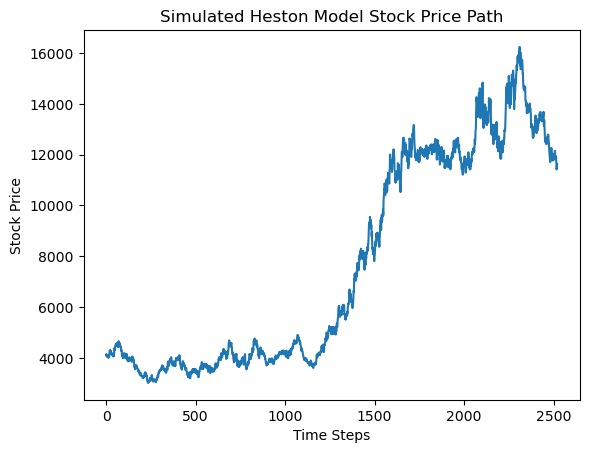

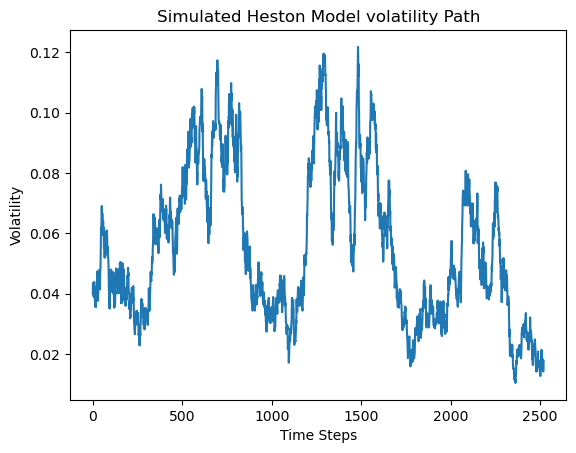

0.003968253968253968


In [155]:
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lambda_, rho , v0
N = 10*252 # 10 years * 252 trading day per year
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

dt = T/N
print(dt)

Set the initial guess for the optimization : 

In [162]:
# true : [0.0485, 1.5, 0.05, 0.18, 0.5, 0.04]
#params_0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.05]
#params_0 = [0.02, 1.5, 0.05, 0.18, 0.5, 0.1]
params_0 = [0.03, 1.3, 0.07, 0.3, 0.6, 0.06]

Use the Nelder-Mead algorithm to minimize the function

In [163]:
def opt_param_research():
    
    def callback(x):
        print("Current parameter vector:", x)

    
    #constraint1 = {'type': 'ineq', 'fun': lambda x: x}#[0] - 1}
    #constraint2 = {'type': 'ineq', 'fun': lambda x: 2 - x[0]}
    #constraints = [constraint1]#, constraint2]
    #bounds = [(0.000001, 2)]*6
    #bounds[1] = (0,2)
    #bounds[4] = (-1,1)
    xopt = minimize(ext_Kalman_filter, params_0, callback=callback, method='Nelder-Mead')
    #result_2 = minimize(obj_function_ext_KF_m, params_0, bounds=bounds, callback=callback)# method='Nelder-Mead',
    #xopt, fopt, _, _, _ = fmin(ext_Kalman_filter, params_0, maxiter=100, callback=callback, disp=True, retall=False, full_output=True)

    #result = fmin(ext_Kalman_filter, params_0, callback=callback)
    print(80*'=')
    print('Optimal parameter set:')
    print(xopt)
    print(80*'=')
    
    return xopt

In [164]:
result_EKF = opt_param_research()

Current parameter vector: [0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
Current parameter vector: [0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
Current parameter vector: [0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
Current parameter vector: [0.03075 1.3325  0.063   0.3075  0.615   0.0615 ]
Current parameter vector: [0.03266667 1.41555556 0.0617037  0.30333333 0.59111111 0.06183333]
Current parameter vector: [0.03266667 1.41555556 0.0617037  0.30333333 0.59111111 0.06183333]
Current parameter vector: [0.03358333 1.36861111 0.05340741 0.30666667 0.58222222 0.06366667]
Current parameter vector: [0.03358333 1.36861111 0.05340741 0.30666667 0.58222222 0.06366667]
Current parameter vector: [0.03358333 1.36861111 0.05340741 0.30666667 0.58222222 0.06366667]
Current parameter vector: [0.03303704 1.43160494 0.05087243 0.30962963 0.60283951 0.06518519]
Current parameter vector: [0.03438272 1.4899177  0.04968176 0.30450617 0.57934156 0.06358025]
Current parameter vector: [0.03438272 

Current parameter vector: [0.04145664 3.16155544 0.05248468 0.30236718 0.59551019 0.02443153]
Current parameter vector: [0.04145664 3.16155544 0.05248468 0.30236718 0.59551019 0.02443153]
Current parameter vector: [0.04063973 3.12035525 0.05280459 0.29862387 0.59386628 0.02561174]
Current parameter vector: [0.04063973 3.12035525 0.05280459 0.29862387 0.59386628 0.02561174]
Current parameter vector: [0.04063973 3.12035525 0.05280459 0.29862387 0.59386628 0.02561174]
Current parameter vector: [0.04450977 3.09418453 0.05255487 0.29860372 0.58088551 0.02848602]
Current parameter vector: [0.04450977 3.09418453 0.05255487 0.29860372 0.58088551 0.02848602]
Current parameter vector: [0.04450977 3.09418453 0.05255487 0.29860372 0.58088551 0.02848602]
Current parameter vector: [0.04450977 3.09418453 0.05255487 0.29860372 0.58088551 0.02848602]
Current parameter vector: [0.04450977 3.09418453 0.05255487 0.29860372 0.58088551 0.02848602]
Current parameter vector: [0.04450977 3.09418453 0.05255487 

Current parameter vector: [0.12286423 3.39364776 0.05704975 0.37024663 0.506872   0.03266618]
Current parameter vector: [0.10948472 3.37652387 0.05630293 0.35769523 0.52168563 0.03119542]
Current parameter vector: [0.10700072 3.39186368 0.0559527  0.35480589 0.52204542 0.0318768 ]
Current parameter vector: [0.10700072 3.39186368 0.0559527  0.35480589 0.52204542 0.0318768 ]
Current parameter vector: [0.10700072 3.39186368 0.0559527  0.35480589 0.52204542 0.0318768 ]
Current parameter vector: [0.10700072 3.39186368 0.0559527  0.35480589 0.52204542 0.0318768 ]
Current parameter vector: [0.10700072 3.39186368 0.0559527  0.35480589 0.52204542 0.0318768 ]
Current parameter vector: [0.12237412 3.40866021 0.05693779 0.37229699 0.50575132 0.03115303]
Current parameter vector: [0.12237412 3.40866021 0.05693779 0.37229699 0.50575132 0.03115303]
Current parameter vector: [0.12237412 3.40866021 0.05693779 0.37229699 0.50575132 0.03115303]
Current parameter vector: [0.12237412 3.40866021 0.05693779 

Current parameter vector: [0.12122854 3.39427507 0.05647767 0.3651213  0.5044311  0.03122347]
Current parameter vector: [0.12191693 3.38343452 0.05652421 0.36548585 0.50452257 0.03110921]
Current parameter vector: [0.12191693 3.38343452 0.05652421 0.36548585 0.50452257 0.03110921]
Current parameter vector: [0.1244782  3.3900985  0.05663266 0.36673984 0.50171375 0.03114252]
Current parameter vector: [0.1244782  3.3900985  0.05663266 0.36673984 0.50171375 0.03114252]
Current parameter vector: [0.1244782  3.3900985  0.05663266 0.36673984 0.50171375 0.03114252]
Current parameter vector: [0.12001355 3.37112005 0.0563598  0.35335867 0.5169717  0.03158418]
Current parameter vector: [0.12436375 3.3592097  0.05663599 0.35819368 0.51163898 0.03157811]
Current parameter vector: [0.12436375 3.3592097  0.05663599 0.35819368 0.51163898 0.03157811]
Current parameter vector: [0.12436375 3.3592097  0.05663599 0.35819368 0.51163898 0.03157811]
Current parameter vector: [0.12436375 3.3592097  0.05663599 

Current parameter vector: [0.13165301 3.40586107 0.0572392  0.28776669 0.62792836 0.03019125]
Current parameter vector: [0.13165301 3.40586107 0.0572392  0.28776669 0.62792836 0.03019125]
Current parameter vector: [0.13409566 3.36551034 0.05726461 0.29001446 0.61845229 0.03002424]
Current parameter vector: [0.13409566 3.36551034 0.05726461 0.29001446 0.61845229 0.03002424]
Current parameter vector: [0.13359    3.36920509 0.0572455  0.28686141 0.62427116 0.03073263]
Current parameter vector: [0.13273784 3.39024641 0.05725995 0.29285515 0.61835699 0.03044235]
Current parameter vector: [0.12887134 3.38683207 0.0570176  0.29097753 0.61918039 0.03010683]
Current parameter vector: [0.13037546 3.4187305  0.05709347 0.28125288 0.64001337 0.02989974]
Current parameter vector: [0.13037546 3.4187305  0.05709347 0.28125288 0.64001337 0.02989974]
Current parameter vector: [0.13259003 3.36558179 0.05716325 0.28638461 0.62610454 0.03033772]
Current parameter vector: [0.13259003 3.36558179 0.05716325 

Current parameter vector: [0.13268041 3.41664534 0.05700891 0.18730405 0.94602857 0.03036279]
Current parameter vector: [0.13268041 3.41664534 0.05700891 0.18730405 0.94602857 0.03036279]
Current parameter vector: [0.13268041 3.41664534 0.05700891 0.18730405 0.94602857 0.03036279]
Current parameter vector: [0.13268041 3.41664534 0.05700891 0.18730405 0.94602857 0.03036279]
Current parameter vector: [0.13268041 3.41664534 0.05700891 0.18730405 0.94602857 0.03036279]
Current parameter vector: [0.13268041 3.41664534 0.05700891 0.18730405 0.94602857 0.03036279]
Current parameter vector: [0.13268041 3.41664534 0.05700891 0.18730405 0.94602857 0.03036279]
Current parameter vector: [0.13442751 3.41022827 0.05716171 0.18460756 0.95725158 0.03004785]
Current parameter vector: [0.13442751 3.41022827 0.05716171 0.18460756 0.95725158 0.03004785]
Current parameter vector: [0.13338545 3.40272932 0.05705088 0.18482929 0.95506441 0.03040783]
Current parameter vector: [0.13338545 3.40272932 0.05705088 

Current parameter vector: [0.13105126 3.3820143  0.0570213  0.15932267 1.10566925 0.03032288]
Current parameter vector: [0.13105126 3.3820143  0.0570213  0.15932267 1.10566925 0.03032288]
Current parameter vector: [0.13105126 3.3820143  0.0570213  0.15932267 1.10566925 0.03032288]
Current parameter vector: [0.1301975  3.3839749  0.05699641 0.15580543 1.12784351 0.03030305]
Current parameter vector: [0.1301975  3.3839749  0.05699641 0.15580543 1.12784351 0.03030305]
Current parameter vector: [0.13043992 3.38158556 0.05696729 0.15878936 1.10907824 0.03051176]
Current parameter vector: [0.13198551 3.39248828 0.05708963 0.15803037 1.11664582 0.03017208]
Current parameter vector: [0.13100688 3.38647714 0.0570251  0.15742664 1.11801688 0.03039064]
Current parameter vector: [0.13100688 3.38647714 0.0570251  0.15742664 1.11801688 0.03039064]
Current parameter vector: [0.13100688 3.38647714 0.0570251  0.15742664 1.11801688 0.03039064]
Current parameter vector: [0.13094079 3.387191   0.05703589 

Current parameter vector: [0.13136121 3.37748092 0.05697702 0.1406115  1.24581375 0.03030692]
Current parameter vector: [0.13241575 3.37301589 0.05704243 0.13901684 1.25858028 0.0304338 ]
Current parameter vector: [0.13241575 3.37301589 0.05704243 0.13901684 1.25858028 0.0304338 ]
Current parameter vector: [0.13140388 3.37460304 0.05701125 0.1404581  1.24883014 0.0302194 ]
Current parameter vector: [0.13140388 3.37460304 0.05701125 0.1404581  1.24883014 0.0302194 ]
Current parameter vector: [0.13092445 3.37540759 0.05696538 0.14017473 1.25061085 0.03043193]
Current parameter vector: [0.13092445 3.37540759 0.05696538 0.14017473 1.25061085 0.03043193]
Current parameter vector: [0.13114041 3.38215672 0.05697117 0.13980678 1.25377628 0.03029703]
Current parameter vector: [0.13183883 3.37259057 0.05704359 0.13723744 1.27532677 0.03035228]
Current parameter vector: [0.13183883 3.37259057 0.05704359 0.13723744 1.27532677 0.03035228]
Current parameter vector: [0.13183883 3.37259057 0.05704359 

Current parameter vector: [0.13069187 3.38817601 0.05697916 0.11456241 1.53032817 0.03054275]
Current parameter vector: [0.13069187 3.38817601 0.05697916 0.11456241 1.53032817 0.03054275]
Current parameter vector: [0.13077625 3.38714831 0.05699038 0.11381236 1.54209472 0.03024758]
Current parameter vector: [0.13077625 3.38714831 0.05699038 0.11381236 1.54209472 0.03024758]
Current parameter vector: [0.13094325 3.38948246 0.05699478 0.11139142 1.57260941 0.03030128]
Current parameter vector: [0.13094325 3.38948246 0.05699478 0.11139142 1.57260941 0.03030128]
Current parameter vector: [0.13094325 3.38948246 0.05699478 0.11139142 1.57260941 0.03030128]
Current parameter vector: [0.13094325 3.38948246 0.05699478 0.11139142 1.57260941 0.03030128]
Current parameter vector: [0.13094325 3.38948246 0.05699478 0.11139142 1.57260941 0.03030128]
Current parameter vector: [0.13094325 3.38948246 0.05699478 0.11139142 1.57260941 0.03030128]
Current parameter vector: [0.13159423 3.38618086 0.05701394 

## Plotting the results:

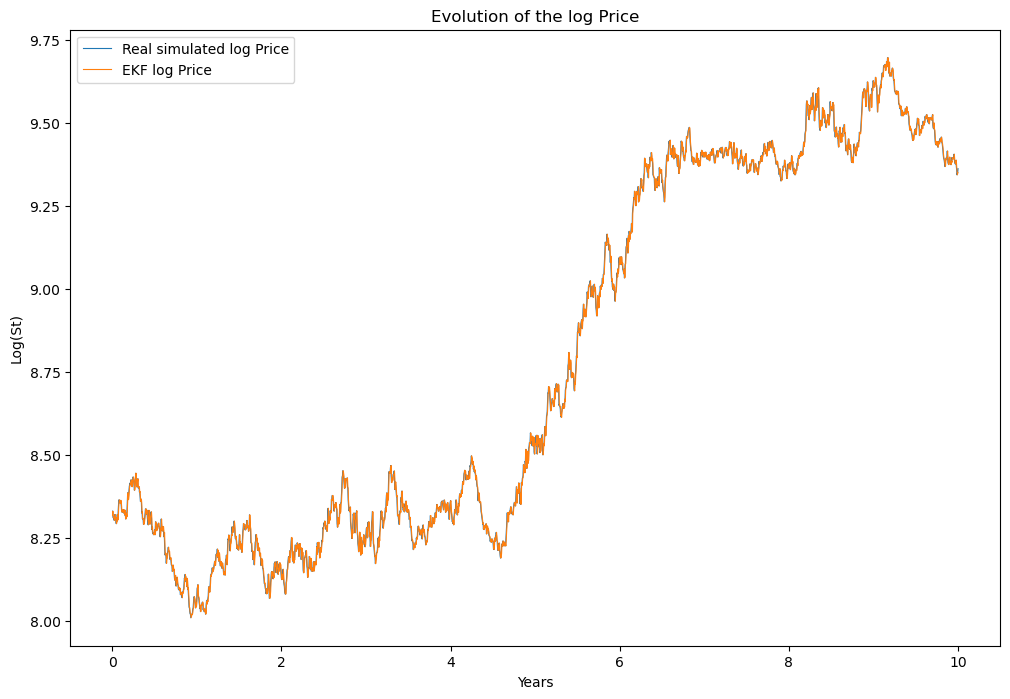

In [168]:
plt.figure(figsize=(12,8))
years = np.arange(y.shape[-1]) * dt
plt.plot(years[1:], y[1:], label = 'Real simulated log Price', linewidth=0.8)
plt.plot(years[1:], y_KF, label = 'EKF log Price', linewidth=0.8)
plt.plot()
plt.title('Evolution of the log Price')
plt.ylabel('Log(St)')
plt.xlabel('Years')
plt.legend()
plt.show()

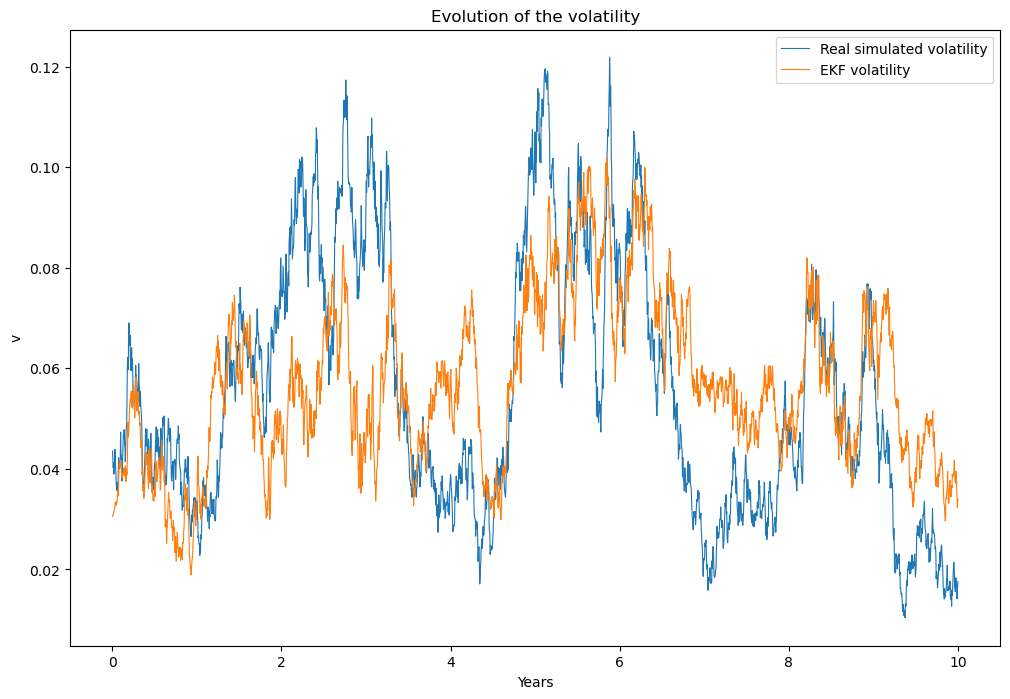

In [169]:
plt.figure(figsize=(12,8))
plt.plot(years[1:], v_[1:], label = 'Real simulated volatility', linewidth=0.8)
plt.plot(years[1:], v_KF, label = 'EKF volatility', linewidth=0.8)
plt.plot()
plt.title('Evolution of the volatility')
plt.ylabel('v')
plt.xlabel('Years')
plt.legend()
plt.show()

## 2. Particle Filtering

### 2.1 Preparing the different functions

In [49]:
def proposal_distribution(N, x_prev, dy, params):
    
    mu, kappa, theta, lambda_, rho = params
    
    m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
    s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
    
    return norm.rvs(m, s, N)

In [50]:
def likelihood(y, x, x_prev, y_prev, params):
    
    mu, kappa, theta, lambda_, rho = params
    
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x_prev*dt)
    
    return norm.pdf(y,m,s)

In [51]:
def transition(x, x_prev, params):
        mu, kappa, theta, lambda_, rho = params
        
        m = 1/(1+1/2*lambda_*rho*dt) * (x_prev + kappa*(theta-x_prev)*dt + 1/2*lambda_*rho*x_prev*dt)
        s = 1/(1+1/2*lambda_*rho*dt) * lambda_ * np.sqrt(x_prev*dt)
        
        return norm.pdf(x, m, s)

In [52]:
def proposal(x, x_prev, dy, params):
        mu, kappa, theta, lambda_, rho = params
        
        m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
        s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
        
        return norm.pdf(x, m, s)

In [53]:
def parameter_states_init(N, bounds):
    # initialize param states
    params_states = np.zeros((len(bounds), N))
    b0, b1, b2, b3, b4 = bounds
    params_states[0] = np.random.rand(N)*(b0[1]-b0[0])+b0[0]
    params_states[1] = np.random.rand(N)*(b1[1]-b1[0])+b1[0]
    params_states[2] = np.random.rand(N)*(b2[1]-b2[0])+b2[0]
    params_states[3] = np.random.rand(N)*(b3[1]-b3[0])+b3[0]
    params_states[4] = np.random.rand(N)*(b4[1]-b4[0])+b4[0]
    return params_states

In [54]:
def resample_state(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. 
    indexes = np.searchsorted(cumulative_sum, np.random.rand(N))
    particles[:] = particles[indexes]
    new_weights = np.ones(len(weights)) / len(weights)
    return particles, new_weights

In [55]:
def resample(x_pred, weights, params_states):
        params_states[0], _ = resample_state(params_states[0], weights)
        params_states[1], _ = resample_state(params_states[1], weights)
        params_states[2], _ = resample_state(params_states[2], weights)
        params_states[3], _ = resample_state(params_states[3], weights)
        params_states[4], _ = resample_state(params_states[4], weights)
        x_pred, weights = resample_state(x_pred, weights)
        return x_pred, weights, params_states

In [56]:
def prediction_density(y, y_prev, x, mu):
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x*dt)
    return norm.pdf(y, m, s)

def prediction_density_v(v, x_prev, dy, lambda_,rho, theta, kappa):#(v, v_prev, x, mu, params):
    #mu, kappa, theta, lambda_, rho = params
    #m = v_prev + (mu-1/2*x)*dt
    #s = np.sqrt(x*dt)
    #return norm.pdf(y, m, s) # cf equation 8.43
    #proposal
    #m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
    #s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
    
    '''print('k', kappa)
    print('t', theta)
    print('x',x_prev)'''
    #transition
    m = 1/(1+1/2*lambda_*rho*dt) * (x_prev + kappa*(theta-x_prev)*dt + 1/2*lambda_*rho*x_prev*dt)
    #print('m',m)
    s = (1/(1+1/2*lambda_*rho*dt) * lambda_ * np.sqrt(x_prev*dt))
        
        
    # last trial=
    #delta = kappa*theta- rho*lambda_*mu-(kappa-0.5*rho*lambda_)*x_prev
    #m = x_prev+delta*dt+rho*y_prev
    return norm.pdf(v, m, s)

In [57]:
def predict(x_pred, particles, y_prev, mu):
    
    y_hat = y_prev + (mu-1/2*x_pred)*dt + np.sqrt(particles*dt)*norm.rvs()
    #print('yhat', y_hat)
    py_hat = np.array([np.mean(prediction_density(y_hat[k], y_prev, x_pred, mu)) for k in range(len(y_hat))])
    
    py_hat = py_hat/sum(py_hat)
    
    return np.sum(py_hat * y_hat)

In [58]:
def predict_v(x_pred, particles, v_prev, mu, lambda_,rho, theta, kappa, weights, params, dy):
    #print('mu', mu)
    #print('lbda', lambda_)
    #print('particles', particles)
    #print('rho',rho)
    #mu, kappa, theta, lambda_, rho = params
    #print('rho_2', rho)
    #v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*x_pred)*dt)-(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs() + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    #v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*particles)*dt)-(mu-1/2*v_prev)*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    # best so far v_hat = v_prev + (theta-1/2*x_pred)*dt - lambda_*rho*(((mu-1/2*x_pred)*dt)-(mu-1/2*v_prev)*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    v_hat = v_prev + (theta-1/2*particles)*dt + lambda_*rho*(((mu-1/2*particles)*dt)-(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs() + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    
    
    #v_hat = v_prev + kappa*(theta-particles)*dt #+ lambda_*rho*(dy -(mu-1/2*particles)*dt) + lambda_*np.sqrt((1-rho**2)*particles*dt)*norm.rvs()# + lambda_*rho*np.sqrt(particles*dt)*norm.rvs()
    #v_hat = x_pred
    #v_hat = x_pred
    #print('ICI',lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs())
    
    #v_hat = 1/(1+1/2*lambda_*rho*dt) * (v_prev + kappa*(theta-v_prev)*dt + 1/2*lambda_*rho*v_prev*dt) + lambda_*np.sqrt((1-rho**2)*v_prev*dt)*norm.rvs() + lambda_*rho*np.sqrt(v_prev*dt)*norm.rvs()
    #v_hat = v_prev + kappa*(theta-v_prev)*dt
    #print('vhat', v_hat)
    # il manque peut etre un kappa juste au dessus
    '''print('vhat', np.shape(v_hat))
    print(np.mean(v_hat))
    print('vprev', np.shape(v_prev))
    print(v_prev)
    '''
    #pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], x_pred, dy, params)) for k in range(len(v_hat))])
    #pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], v_prev, dy, params)) for k in range(len(v_hat))])
    pv_hat = np.array([np.mean(prediction_density_v(v_hat[k], particles[k], dy,lambda_,rho, theta,kappa)) for k in range(len(v_hat))])
    #print('pvhat', pv_hat)
    pv_hat = pv_hat/sum(pv_hat)
    #print('pvhat', pv_hat)
    #print('prod',(pv_hat * v_hat))
    #print('return', np.sum(pv_hat * v_hat))
    return np.sum(pv_hat * v_hat)
    #return(np.sum(v_hat*weights))

In [63]:
def _neff(weights):
        return 1. / np.sum(np.square(weights))

In [219]:
def particle_filter(params, N):
    global y_PF, v_PF ,v_PF_bis
    
    mu, kappa, theta, lambda_, rho, v_0 = params
    
    print(params[:-1])
    
    params_states = parameter_states_init(N, params[:-1])
    
    y_PF = np.zeros(N)
    v_PF = np.zeros(N)
    v_PF_bis = np.zeros(N)
    
    y_PF[0] = y[0]
    v_PF[0] = v_0
    v_PF_bis[0] = v_0
    
    weights = np.array([1/N] * N)
    
    particles = norm.rvs(v_0, 0.02, N)
    particles = np.maximum(1e-4, particles)
    
    params_steps = np.zeros((len(params)-1, len(y)))
    params_steps.transpose()[0] = np.mean(params_states, axis=1)
    print(N)
    for i in range(1, N):
        dy = y[i] - y[i-1]
        
        x_pred = proposal_distribution(N, particles, dy, params_states)
        x_pred = np.maximum(1e-3, x_pred)
        
        Li = likelihood(y[i], x_pred, particles, y[i-1], params_states)
        I = proposal(x_pred, particles, dy, params_states)
        T = transition(x_pred, particles, params_states)
        weights = weights * (Li*T/I)
        weights = weights/sum(weights)
        
        if _neff(weights) < 0.7*N:
            print('resampling since: {}'.format(_neff(weights)))
            x_pred, weights, params_states = resample(x_pred, weights, params_states)
        
        y_hat = predict(x_pred, particles, y[i-1], np.mean(params_states[0]))
        y_PF[i] = y_hat
        
        #v_PF[i] = predict_v(x_pred, particles, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),weights, params_states, dy)# np.sum(x_pred * weights)
        #v_PF[i] = predict_v(x_pred * weights, particles* weights, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),weights, params_states, dy)# np.sum(x_pred * weights)
        v_PF_bis[i] = predict_v(x_pred, particles, v_PF[i-1], np.mean(params_states[0]), np.mean(params_states[3]),np.mean(params_states[4]),np.mean(params_states[2]),np.mean(params_states[1]),weights, params_states, dy)# np.sum(x_pred * weights)
        #v_PF[i] = np.mean(x_pred)
        v_PF[i] = np.sum(x_pred * weights)
        particles = x_pred
        params_steps.transpose()[i] = np.sum(np.multiply(params_states, weights[np.newaxis, :]), axis=1)
        
        print("Done with iter: {}".format(i))
        
    return (v_PF, v_PF_bis, params_steps, y_PF)

### 2.2 Running the algorithm

[1.5  0.05 0.18 0.5  0.04]
T: 10   N: 500   dt: 0.02
0.04
0.04


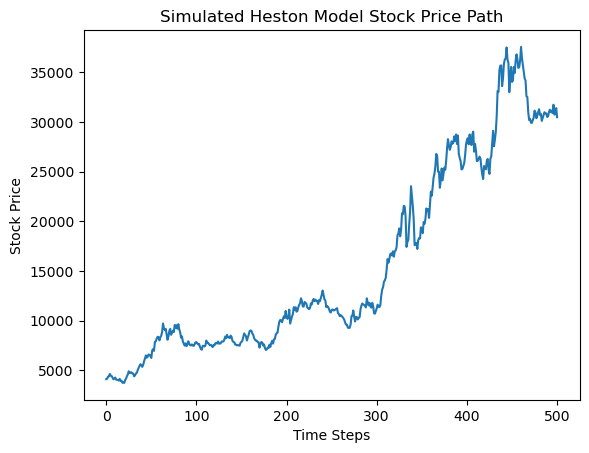

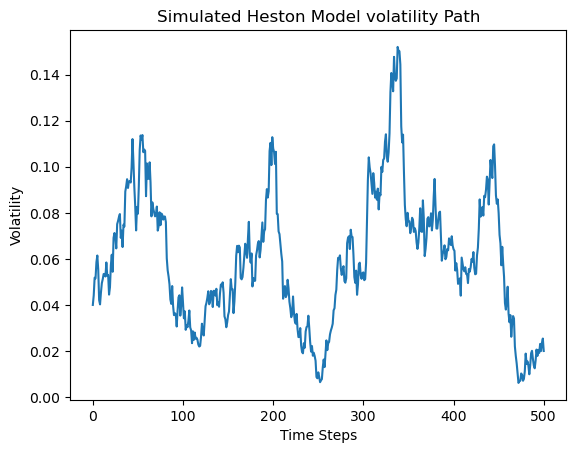

0.02


In [220]:
S0 = 4100
r = 0.0485
mu = r
params = [mu, 1.5, 0.05, 0.18, 0.5, 0.04]
#.        mu, kappa, theta, lambda_, rho , v0
N = 500
T = 10

params_sim = np.zeros(5)
params_sim[0] = params[1]# kappa  
params_sim[1] = params[2]#theta  
params_sim[2] = params[3]#sigma  
params_sim[3] = params[4]#rho   
params_sim[4] = params[5]#v0  
print(params_sim)
prices, v_, y = heston_simulated_prices(params_sim, N, T, S0, r, mu, plot = True)

dt = T/N
print(dt)

In [221]:
print(params)

[0.0485, 1.5, 0.05, 0.18, 0.5, 0.04]


In [222]:
mu = (0.01, 0.05)
kappa = (0.5, 3)
theta = (0.02, 0.2)
lambda_ = (0.01, 0.91)
rho = (-0.5, 1)
v_0 = params[-1]

params_0 = [mu, kappa, theta, lambda_, rho, v_0]

In [223]:
v, v_bis, param_steps, obs = particle_filter(params_0, N)

[(0.01, 0.05), (0.5, 3), (0.02, 0.2), (0.01, 0.91), (-0.5, 1)]
500
resampling since: 255.42463160849533
Done with iter: 1
resampling since: 174.47379901637262
Done with iter: 2
Done with iter: 3
resampling since: 259.4828438675674
Done with iter: 4
Done with iter: 5
Done with iter: 6
resampling since: 322.2951955407968
Done with iter: 7
resampling since: 321.5097272478276
Done with iter: 8
Done with iter: 9
Done with iter: 10
resampling since: 332.93592084976433
Done with iter: 11
Done with iter: 12
resampling since: 269.6222090190588
Done with iter: 13
resampling since: 240.60347502903423
Done with iter: 14
resampling since: 296.376698235595
Done with iter: 15
Done with iter: 16
Done with iter: 17
resampling since: 294.2260883849332
Done with iter: 18
Done with iter: 19
resampling since: 340.399954609939
Done with iter: 20
resampling since: 249.35001890192245
Done with iter: 21
Done with iter: 22
Done with iter: 23
resampling since: 332.8773579360455
Done with iter: 24
Done with iter:

Done with iter: 262
Done with iter: 263
resampling since: 344.46978349521584
Done with iter: 264
Done with iter: 265
Done with iter: 266
resampling since: 253.99825496681544
Done with iter: 267
Done with iter: 268
Done with iter: 269
resampling since: 284.1244469975966
Done with iter: 270
Done with iter: 271
resampling since: 89.83297505500468
Done with iter: 272
Done with iter: 273
Done with iter: 274
Done with iter: 275
resampling since: 339.92378255335757
Done with iter: 276
Done with iter: 277
Done with iter: 278
Done with iter: 279
Done with iter: 280
resampling since: 316.8466683838429
Done with iter: 281
resampling since: 321.2607174955404
Done with iter: 282
Done with iter: 283
Done with iter: 284
Done with iter: 285
resampling since: 328.4042676059957
Done with iter: 286
Done with iter: 287
Done with iter: 288
Done with iter: 289
Done with iter: 290
Done with iter: 291
resampling since: 348.442609072402
Done with iter: 292
Done with iter: 293
Done with iter: 294
Done with iter

### 2.3 Plotting the results:

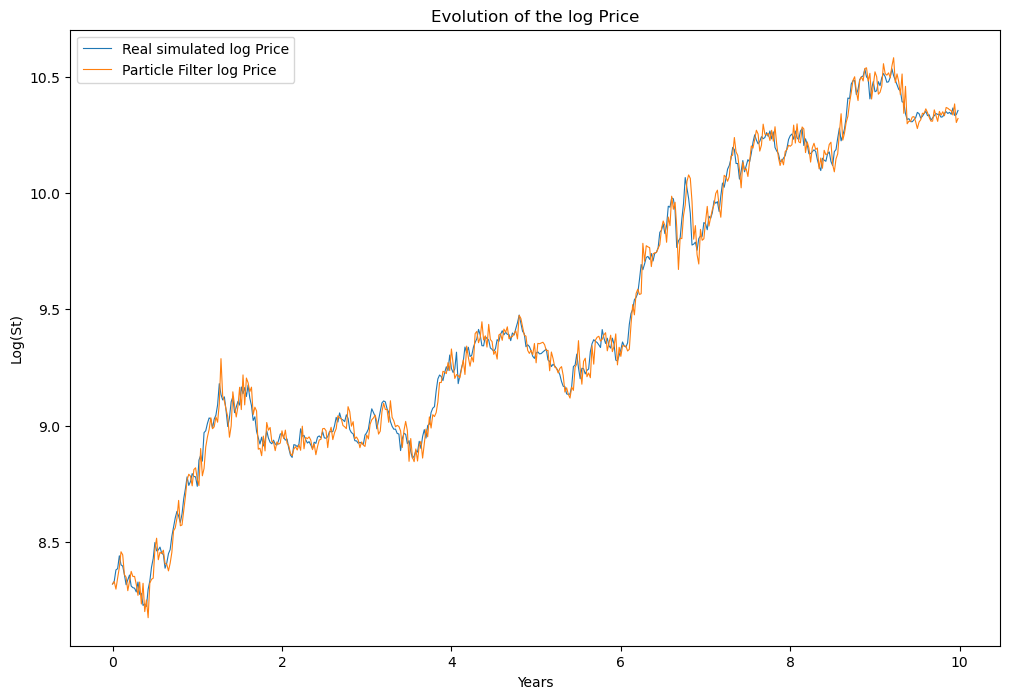

In [224]:
plt.figure(figsize=(12,8))
years = np.arange(obs.shape[-1]) * (T/N)
plt.plot(years, y[:-1], label = 'Real simulated log Price', linewidth=0.8)
plt.plot(years, obs, label = 'Particle Filter log Price', linewidth=0.8)
plt.plot()
plt.title('Evolution of the log Price')
plt.ylabel('Log(St)')
plt.xlabel('Years')
plt.legend()
plt.show()

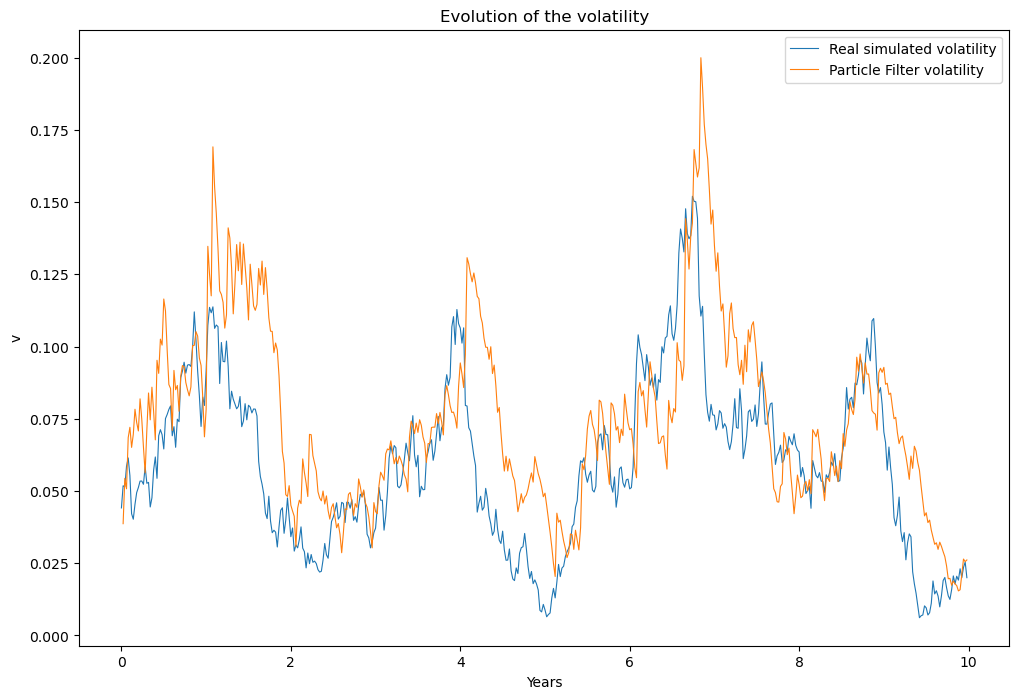

In [225]:
plt.figure(figsize=(12,8))
years = np.arange(v.shape[-1]) * (T/N)
plt.plot(years, v_[1:], label = 'Real simulated volatility', linewidth=0.8)
plt.plot(years[1:], v[1:], label = 'Particle Filter volatility', linewidth=0.8)
#plt.plot(years[1:], v_bis[1:], label = 'Particle Filter volatility', linewidth=0.8)
plt.plot()
plt.title('Evolution of the volatility')
plt.ylabel('v')
plt.xlabel('Years')
plt.legend()
plt.show()